In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime

matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')

In [3]:
import nsfg
df = nsfg.ReadFemPreg()


In [4]:
live = df[df.outcome == 1]
len(live)

9148

In [5]:
firsts = df[df.birthord==1]
others = df[df.birthord>1]
len(firsts), len(others)

(4413, 4735)

In [6]:
a = firsts.prglngth.mean()
b = others.prglngth.mean()

c = (a - b)*168.0

print("Mean pregnancy length for first borns: {}".format(a))
print("Mean pregnancy length for others: {}".format(b))
print("Difference between mean first and others pregnancy lengths in hrs: {}".format(c))

Mean pregnancy length for first borns: 38.60095173351461
Mean pregnancy length for others: 38.52291446673706
Difference between mean first and others pregnancy lengths in hrs: 13.11026081862832


In [7]:
def get_value(vals):
    import random
    pval = random.uniform(0,100)
    #print(pval)
    return np.percentile(vals,pval)


def get_group(vals, numberofsubjects):
    """Returns a pandas series."""
    import random
    a = list()
    for i in range(numberofsubjects):
        try:
            b = get_value(vals)
            a.append(b)
        except:
            pass
    c = pd.Series(a)
    return c

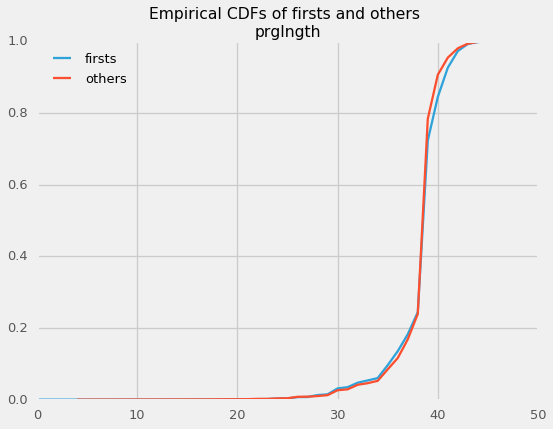

In [8]:

firsts_data = firsts.prglngth.value_counts(normalize=True).sort_index().cumsum()
others_data = others.prglngth.value_counts(normalize=True).sort_index().cumsum()

dfdata = pd.DataFrame({'firsts': firsts_data,
                     'others': others_data})
dfdata = dfdata.fillna(method='ffill')
dfdata.plot(figsize=(8,6), title = "Empirical CDFs of firsts and others \n" + 
           "prglngth");

In [9]:
firsts_prglngth_vals = firsts.prglngth.values
others_prglngth_vals = others.prglngth.values

firstssamp = get_group(firsts_prglngth_vals, 150000)
otherssamp = get_group(others_prglngth_vals, 150000)

In [10]:
(firstssamp > otherssamp).values.mean()


0.37891333333333332

## <font color='steelblue'>The Estimation Game</font>

```
Let’s play a game. I think of a distribution, and you have to guess what it is. I’ll give you two hints: it’s a normal distribution, and here’s a random sample drawn from it:
[-0.441, 1.774, -0.101, -1.138, 2.975, -2.138]

What do you think is the mean parameter, µ, of this distribution?

One choice is to use the sample mean, x, as an estimate of µ. In this example, x is 0.155, so it would be reasonable to guess µ = 0.155. This process is called estimation, and the statistic we used (the sample mean) is called an estimator.
```

In [35]:
nums = [-0.441, 1.774, -0.101, -1.138, 2.975, -2.138]

numser = pd.Series(nums)
print(numser.mean(),numser.std())


0.15516666666666667 1.8933573795421366


In [13]:
import scipy
results = scipy.stats.bayes_mvs(numser.as_matrix())
results

(Mean(statistic=0.15516666666666667, minmax=(-1.4023849490394598, 1.7127182823727924)),
 Variance(statistic=5.9746702777777765, minmax=(1.6190790450036288, 15.647649794494102)),
 Std_dev(statistic=2.2519897075579607, minmax=(1.2724303694126562, 3.9557110352620684)))

If there are no outliers, the sample mean minimizes the **mean squared error** (MSE). That is, if we play the game many times, and each time compute the error $\bar{x} - \mu$, the sample mean minimizes:

$
MSE = \frac{1}{m} \sum (\bar{x} - \mu)^{2}
$

where $m$ is the number of times you play the estimation game, not to be confused with $n$, which is the size of the sample used to compute $\bar{x}$.



In [14]:
import math

def RMSE(estimates, actual):
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return math.sqrt(mse)

In [21]:
def Estimate1(n=7, m=1000):
    import random
    mu = 0
    sigma = 1

    means = []
    medians = []
    for _ in range(m):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)

    print('rmse xbar', RMSE(means, mu))
    print('rmse median', RMSE(medians, mu))

Again, $n$ is the size of the sample, and $m$ is the number of times we play the game. ```means``` is the list of estimates based on $\bar{x}$. ```medians``` is the list of medians. 

In the function ```RMSE```, ```estimates``` is the list of estimates, ```actual``` is the actual thing being estimated. In practice, of course, we don't know ```actual```; if we did, we wouldn't have to estimate it. The purpose of the experiment is to compare the performance of the two estimators.

In [22]:
Estimate1()

rmse xbar 0.3837896535522685
rmse median 0.4625434945810025


When I ran this code, the RMSE of the sample mean was 0.3837, which means that if we $\bar{x}$ to estimate the mean of this distribution, based on a sample with $n=7$, we should expect to be off by 0.3837 on average. Using the median to estimate the mean yields RMSE of 0.46254, which confirms that $\bar{x}$ yields lower RMSE, at least for this example.


Minimizing MSE is a nice property, but it's not always the best strategy. For example, suppose we are estimating the distribution of wind speeds at a building site. If the estimate is too high, we might overbuild the structure, increasing its cost. But if it's too low, the building might collapse. Because cost as a function of error is not symmetric, minimizing MSE is not the best strategy.

AS another exmaple, suppose I roll three six-sided dice and ask you to predict the total. If you get it exactly right, you get a prize; otherwise you get nothing. In this case the value that minimizes the MSE is 10.5

In [25]:
def Dice_3_6(trials = 800000, n=3):
    import random
    totals = []
    dicevalues = range(1,7)
    for _ in range(trials):
        rolls = [random.choice(dicevalues) for i in range(n)]
        total = np.sum(rolls)
        totals.append(total)

    print('average of the total of rolling three dice', np.mean(totals))
    totalsser = pd.Series(totals)
    print(totalsser.value_counts(normalize=True))

In [26]:
Dice_3_6()

average of the total of rolling three dice 10.50150125
10    0.125825
11    0.125584
9     0.115679
12    0.115414
13    0.097589
8     0.096729
14    0.069440
7     0.069282
6     0.046294
15    0.046170
5     0.027856
16    0.027690
17    0.013705
4     0.013491
3     0.004666
18    0.004586
dtype: float64


In this case the value that minimizes the MSE is 10.5, but that would be a bad guess, becauase the total of three dice is never 10.5. For this game, you want an estimator tha thas the highest chance of being right, which is a **maximum likelihood estimator** (MLE). If you pick 10 or 11, your chance of winning is 1 in 8, and that's the best you can do.

## <font color='steelblue'>Guess the variance</font>


I'm thinking of a distribution. It's a normal distribution, and here's a (familiar) sample:

[-0.441, 1.774, -0.101, -1.138, 2.975, -2.138]

What do you think is the variance,  $\sigma^{2}$  of my distribution? Again, the obvious choice is to use the sample variance,  $S^{2}$ , as an estimator:

$
S^{2} = \frac{1}{n} \sum (x_{i} - \bar{x})^{2} 
$

For large samples,  $S^{2}$  is an adequate estimator, but for small samples it tends to be too low. Because of this unforunate property, it is called a biased estimator. An estimator is unibiased if the expected total (or mean) error, after many iterations of the estimation game, is 0.
Fortunately, there is another simple statistic that is an ubiased estimator of  $\sigma^{2}$ :

$
S^{2}_{n-1} = \frac{1}{n-1}\sum (x_{i} - \bar{x})^{2}
$

For an explanation of why  $S^{2}$  is biased, and a proof that $S^{2}_{n-1}$  is unbiased, see http://wikipedia.org/wiki/Bias_of_an_estimator
The biggest problem with this estimator is that its name and symbol are used inconsistently. The name "sample variance" can refer to either  $S^{2}$  or  $S^{2}_{n-1}$ , and the symbol  $S^{2}$  is used for either or both.
Here is a function that simulates the estimation game and tests the performance of  $S^{2}$  and  $S^{2}_{n-1}$ :


In [27]:
def MeanError(estimates, actual):
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

In [30]:
import random
def Estimate2(n=7, m=100000):
    mu = 0
    sigma = 1

    estimates1 = []
    estimates2 = []
    for _ in range(m):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('mean error biased', MeanError(estimates1, sigma**2))
    print('mean error unbiased', MeanError(estimates2, sigma**2))

Again, $n$ is the sample size and $m$ is the number of times we play the game. ```np.var``` computes $S^{2}$ by default and $S^{2}_{n-1}$ if you provide the argument ```ddof=1```, which stands for delta degrees of freedom. I won't explain that term, but you can read about it at http://en.wikipedia.org/wiki/Degrees_of_freedom .
```MeanError``` computes the mean difference between the estimate and the actual value.

In [31]:
Estimate2()

mean error biased -0.141332265273
mean error unbiased 0.00177902384842


When I ran this code, theb mean error for $S^{2}$ was -0.141. As expected, this biased estimator tends to be too low. For $S_{n-1}^{2}$, the mean error was 0.00177, much much smaller. As ```m``` increases, we expect the mean error for $S_{n-1}^{2}$ to approach 0.

Properties like MSE and bias are long-term expectations based on many iterations of the estimation game. By running simulations like the ones in this chapter, we can compare estimators and check whether they have the desired properties.

But when you apply an estimator to real data, you just get one estimate. It would not be meaningful to say that the estimate is unbiased; being unbiased is a property of the estimator, not the estimate.

After you choose an estimator with appropriate properties, and use it to generate an estimate, the next step is to characterize the uncertainty of the estimate, which is the topic of the next section.

## <font color='steelblue'>Sampling distributions</font>

Suppose you are a scientist studying gorillas in a wildlife preserve. You want to know the average weight of the adult female gorillas in the preserve. To weigh them, you have to tranquilize them, which is dangerous, expensive, and possibly harmful to the gorillas. But if it is important to obtain this information, it might be acceptable to weigh a sample of 9 gorillas. Let's assume that hte population of the preserve is well known, so we can choose a representative sample of adult females. We could use the sample mean, $\bar{x}$, to estimate the unknown populatin mean, $\mu$.

Having weighed 9 female gorillas, you might find $\bar{x} = 90$ kg and a sample standard deviation $S = 7.5$ kg. The sample mean is an unbiased estimator of $\mu$ and in the long run it minimizes MSE. So if you report a single estimate that summarizes the results, you would report 90 kg.

But how confident should you be in this estimate? If you only weigh $n = 9$ gorillas out of a much bigger population, you might be unlucky and choose the 9 heaviest gorillas (or the 9 lightest ones) just by chance. Variation in the estimate caused by random selection is called **sampling error**.

To quantify sampling error, we can simulate the sampling process with hypothetical values of $\mu$ and $\sigma$ and see how much $\bar{x}$ varies.

Since we don't know the actual values of $\mu$ and $\sigma$ in the population, we'll use the estimates $\bar{x}$ and $S$. So the question we answer is: "If the actual values of $\mu$ and $\sigma$ were 90 kg and 7.5 kg, and we ran the same experiment many times, how much would the estimated mean, $\bar{x}$, vary?"

The following function answers that question:

In [87]:
nums = [-0.441, 1.774, -0.101, -1.138, 2.975, -2.138]

numser = pd.Series(nums)
print(numser.mean(),numser.std())

0.15516666666666667 1.8933573795421366


In [88]:
import scipy
results = scipy.stats.bayes_mvs(numser.as_matrix(),alpha=.9)
results

(Mean(statistic=0.15516666666666667, minmax=(-1.4023849490394598, 1.7127182823727924)),
 Variance(statistic=5.9746702777777765, minmax=(1.6190790450036288, 15.647649794494102)),
 Std_dev(statistic=2.2519897075579607, minmax=(1.2724303694126562, 3.9557110352620684)))

In [89]:
from scipy.stats import t

def SimulateSample(mu=numser.mean(), sigma=numser.std(), n = numser.shape[0], m=8000):
    means = []
    for j in range(m):
        #xs = np.random.normal(mu, sigma, n)
        #xs = np.random.standard_t(df=n-1,size=n)
        xs = t.rvs(df=n-1,loc=mu,scale=sigma,size=n)
        xbar = np.mean(xs)
        means.append(xbar)

    meansser = pd.Series(means)
    meanscdf = meansser.value_counts(normalize=True).sort_index().cumsum()
    ci = meansser.quantile(.05), meansser.quantile(.95)
    print(ci)
    stderr = RMSE(means, mu)
    print(stderr)
    return meansser, meanscdf

In [90]:
meansser, meanscdf = SimulateSample()

(-1.4838371378653745, 1.7661308449876623)
1.0009838529666009


In each iteration, we choose $n$ values from a normal distribution with the given parameters, and compute the sample mean, ```xbar```. We run 1000 simulations and then compute the distribution, ```meanscdf``` of the estimates. The result is shown on the next slide: This distribution is called the **sampling distribution** of the estimator. It shows how much the estimates would vary if we ran the experiment over and over.

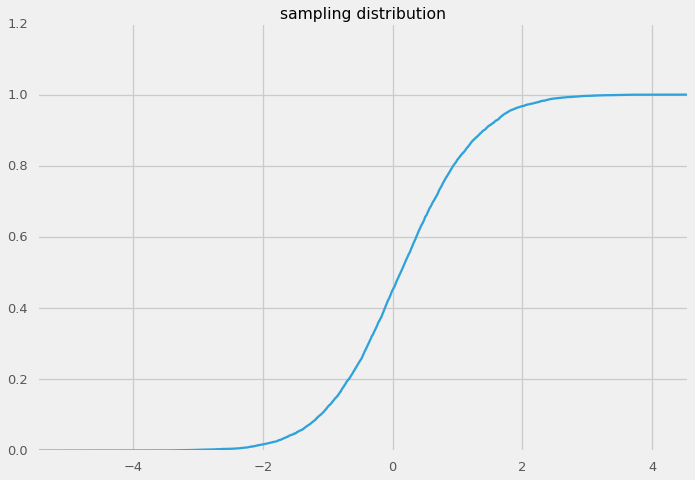

In [91]:
meanscdf.plot(drawstyle='step',title="sampling distribution");

The mean of the sampling distribution is pretty close to the hypothetical value of $\mu$, which means that the experiment yields the right answer, on average. After 1000 tries, the lowest result is -0.2, and the highest is 0.6. This range suggests that the estimate might be off by as much as 4.5.

There are two common ways to summarize the sampling distribution:

* **Standard error** (SE) is a measure of how far we expect the estimate to be off, on average. For each simulated experiment, we comput the error, $\bar{X} - \mu$, and then compute the root mean squared error (RMSE). In this example, it is roughly .14
* A **confidence interval** (CI) is a range that includes a given fraction of the sampling distribution. For example, the 90% confidence interval is the range from the 5th to the 95th percentile. In this example, the 90% is (-0.0753, 0.3856)

standard errors and confidence intervals are the source of much confusion:

* People often confuse standard error and standard deviation. Remember that standard deviation describes variability in a measured quantity; in this example, the standard deviation of gorilla weight is 7.5 kg. Standard error describes the variability in an estimate. In this example, the standard error of the mean, based on the sample of 9 measurements, is 2.44 kg. One way to remember the difference is that, as sample size increases, standard error gets smaller; standard deviation does not.
* People often think that there is a 90% probability that the actual parameter,  $\mu$, falls in the 90% confidence interval. Sadly, that is not true. If you want to make a claim like that, you have to use Bayesian methods. The sampling distribution answers a different question: it gives you a sense of how realiable an estimate is by telling you how much it would vary if you ran the experiment again.

It is important to remember that confidence intervals and standard errors only quantify sampling error; that is, error due to measuring only part of the population

## <font color='steelblue'>Exercise</font>

Suppose you draw a sample with size $n = 10$ from a guassian distribution with $\sigma=3$ and $\mu=15$. Simulate this experiment 1000 times and plot the sampling distributoin of the estimate $\bar{x}$, compute the standard error of the estimate and the 90% confidence interval.

Repeat the experiment with a few different values of $n$ and make a plot of standard error versus $n$.

In [94]:
def exercise(n=10,m=1000):
    sigma = 3
    mu = 15
    means = []
    for _ in range(m):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        means.append(xbar)
    stderr = RMSE(means, mu)
    print(stderr)
    meansser = pd.Series(means)
    meanscdf = meansser.value_counts(normalize=True).sort_index().cumsum()
    ci = meansser.quantile(0.05), meansser.quantile(.95)
    print(ci)
    meanscdf.plot(drawstyle='steps')

0.9377424681279896
(13.517325963187192, 16.588736463646427)


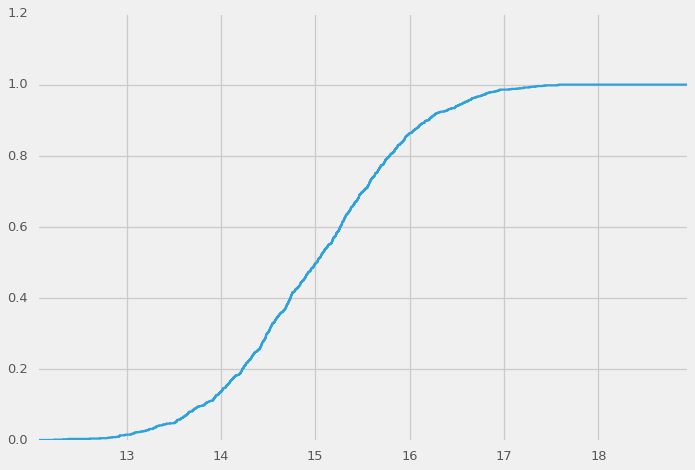

In [95]:
exercise()

In [96]:
def exercise_again(n=10,m=1000):
    sigma = 3
    mu = 15
    means = []
    for _ in range(m):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        means.append(xbar)
    stderr = RMSE(means, mu)
    meansser = pd.Series(means)
    meanscdf = meansser.value_counts(normalize=True).sort_index().cumsum()
    ci = meansser.quantile(0.05), meansser.quantile(.95)
    return n, stderr

In [97]:
nlist = []
stderrlist = []

for k in range(10,1000):
    n, stderr = exercise_again(n=k)
    nlist.append(n)
    stderrlist.append(stderr)
    
dfst = pd.DataFrame({'standard_error': stderrlist,
                    'n': nlist})

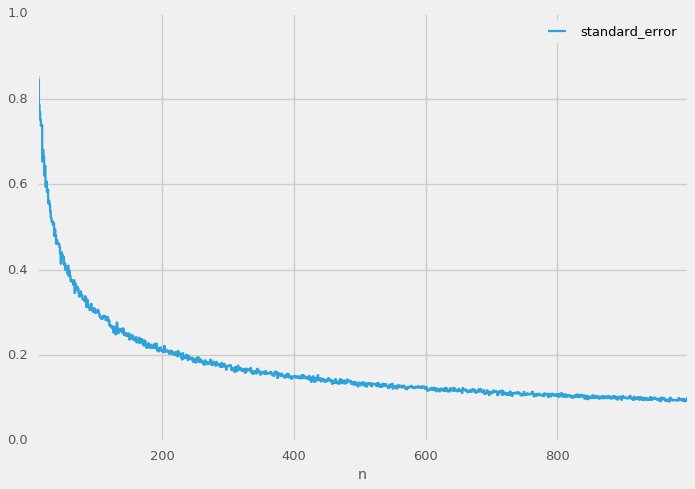

In [98]:
dfst.plot(x='n',y='standard_error',drawstyle='steps');

## <font color='steelblue'>Detour: from the Cartoon Guide to Statistics</font>

Let's replicate the analytic analysis about "Senator Astute", using these computational methods instead.
We are trying to estimate the population probability $p$ based on the sample measurement $\hat{p}$, the percentage of voters that are in favor of Senator Astute.
 
The data is:

* n = 1000
* x = 550 
* $\hat{p} = .85$

This is describing a binomial distribution. Go through the same exercise as above, but this time use a binomial distribution with

* n = n
* p = $\hat{p}$

Find the 95% confidence interval of our estimate for the poopulation parameter $p$:

In [143]:
from scipy.stats import binom
from scipy.stats import norm

def SenatorAstute(level = .99, p = .55, n = 1000, m=8000):
    xs = binom.rvs(n, p, size=m)/n
    pser = pd.Series(xs)
    low, high  = norm.interval(level)
    pcdf = pser.value_counts(normalize=True).sort_index().cumsum()
    ci = pser.quantile((1-level)/2), pser.quantile((1+level)/2)
    print("confidence level: {} is the interval, {} is the ci".format(level, ci))
    stderr = RMSE(xs, p)
    print("stderr: {}".format(stderr))
    bestestimatelow = p + low*stderr
    bestestimatehigh = p + high*stderr
    print("best estimate: {} to {}".format(bestestimatelow, bestestimatehigh))
    return pser, pcdf


In [144]:
from scipy.stats import norm

norm.interval(.99)

(-2.5758293035489004, 2.5758293035489004)

In [145]:
pser, pcdf = SenatorAstute()

confidence level: 0.99 is the interval, (0.51000000000000001, 0.59099999999999997) is the ci
stderr: 0.01568992909480471
best estimate: 0.5095854208669977 to 0.5904145791330024


## <font color='steelblue'>Chapter 9: Hypothesis testing</font>

The code for this chapter is in ```hypothesis.py```

### <font color='steelblue'>9.1 Classical hypothesis testing</font>

Exploring the data from the NSFG, we saw several "apparent effects," including differences between first babies and others. So far we have taken these effects at face value; in this chapter, we put them to the test.

The fundamental question we want to address is whether the effects we see in a sample are likely to appear in the larger population. For example, in the NSFG sample we see a difference in mean pregnancy length for first babies and others. We would like to know if that effect reflects a real difference for women in the U.S., or if it might appear in the sample by chance.

There are several ways we could formulate this question, including Fisher null hypothesis testing, Neyman-Pearson decision theory, and Bayesian inference. What I present here is a subset of all three that makes up most of what people use in practice, which I will call **classical hypothesis testing**.

The goal of calssical hypothesis testing is to amswer the question, "Given a sample and an apparent effect, what is the probability of seeing such an effect by chance?"

Here's how we answer that question:

* The first step is to quantify the size of the apparent effect by choosing a **test statistic**. In the NSFG example, the apparent effect is a difference in pregnancy length between first babies and others, so a natural choice for the test statistic is the difference in means between the two groups.
* The second step is to define a **null hypothesis**, which is a model of the system based on the assumption that the apparent effect is not real. In the NSFG example the null hypothesis is that there is no difference between first babies and others; that is, that pregnancy lengths for both groups have the same distribution
* The third step is to compute **p-value**, which is the probability of seeing the apparent effect if the null hypothesis is true. In the NSFG example, we would compute the acutal difference in means, then compute the probabilty of seeing a difference as big, or bigger, under the null hypothesis.
* the last step is to interpret the result. If the p-value is low, the effect is said to be **statistically significant**, which means that it is unlikely to have occurred by chance. In that case we infer that the effect is more likely to appear in the larger population.


The logic of this process is similar to a proof by contradiction. To prove a mathematical statement, A, you assume temporarily that A is false. If that assumption leads to a controdiction, you conclude that A must actually be true.


Similarly, to test a hypothesis like, "The effect is real," we assume, temporarily, that it is not. That's the null hypothesis. Based on that assumption, we compute the probability of the apparent effect. That's the p-value. If the p-value is low, we conclude that the null hypothesis is unlikely to be true.

A coin is tossed 250 times and we see 140 heads (successes) and 110 tails (fails).

Is there enough evidence to state that the coin is not a **fair** coin?

Binomial distribution with $p=.5$ is the null hypothesis.

In [100]:
from scipy.stats import binom
n, p = 250, .5
rv = binom(n, p)

print(rv.cdf(140))
print(rv.sf(140))

0.975146606105
0.0248533938951


In [101]:
(rv.cdf(250) - rv.cdf(140)) + (rv.cdf(110))

0.058063969515125088

In [102]:
def RunModel(n=250, m=10000):
    headslist = []
    for _ in range(m):
        sample = [random.choice([0,1]) for _ in range(n)]
        heads = np.sum(sample)
        headslist.append(heads)
    headser = pd.Series(headslist)
    headscdf = headser.value_counts(normalize=True).sort_index().cumsum()
    headscdf.plot(drawstyle='steps')
    return headscdf

0.059499999999999921

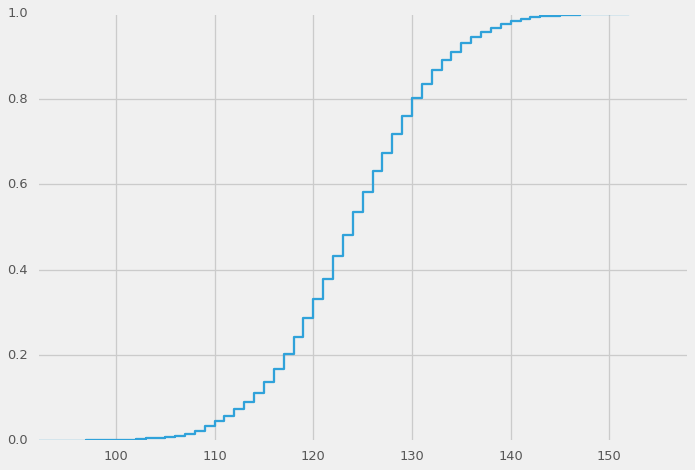

In [104]:
headscdf = RunModel()
1. - headscdf.loc[140] + headscdf.loc[110]

How should we interpret this result? By convention, 5% is the threshold of statistical significance. If the p-value is less than 5%, the effect is considered significant; otherwise it is not.

But the choice of 5% is arbitrary, and (as we will see later) the p-value depends on the choice of the test statistics and the model of the null hypothesis. So p-values should not be considered precise measurements.

I recommend interpreting p-values according to their order of magnitude: if the p-value is less than 1%, the effect is unlikely to be due to chance; if it is greater than 10%, the effect can plausibly be explained by chance. P-values between 1% and 10% should be considered borderline. So in this example I conclude that the data do not provide strong evidence that the coin is biased or not.

In [154]:
psercoin, pcdfcoin = SenatorAstute(p=140/250, n = 250)

confidence level: 0.99 is the interval, (0.47599999999999998, 0.64000000000000001) is the ci
stderr: 0.03144379112002875
best estimate: 0.4790061614183593 to 0.6409938385816408


In [156]:
psercoin, pcdfcoin = SenatorAstute(level=.95,p=140/250, n = 250)

confidence level: 0.95 is the interval, (0.5, 0.624) is the ci
stderr: 0.031466871468260056
best estimate: 0.4983260652160593 to 0.6216739347839407


## <font color='steelblue'>Testing a difference in means</font>

For these examples, the null hypothesis is that the distributions for the two groups are the same. One way to model the null hypothesis is by **permutation**; that is, we can take values for first babies and others and shuffle them, treating the two groups as one big group:

In [106]:
firstsbabylengths = firsts.prglngth.dropna().as_matrix()
othersbabylengths = others.prglngth.dropna().as_matrix()

pooledlengths = np.hstack((firstsbabylengths, othersbabylengths))

print(firstsbabylengths.shape, othersbabylengths.shape, pooledlengths.shape)

n = firstsbabylengths.shape[0]

print(n)

(4413,) (4735,) (9148,)
4413


In [107]:
def runpool(one, two, m = 1000):
    difflist = []
    pool = np.hstack((one, two))
    n = one.shape[0]
    for _ in range(m):
        np.random.shuffle(pool)
        new_one, new_two = pool[:n], pool[n:]
        difference = np.abs(new_one.mean() - new_two.mean())
        difflist.append(difference)
    diffser = pd.Series(difflist)
    diffcdf = diffser.value_counts(normalize=True).sort_index().cumsum()
    return diffcdf

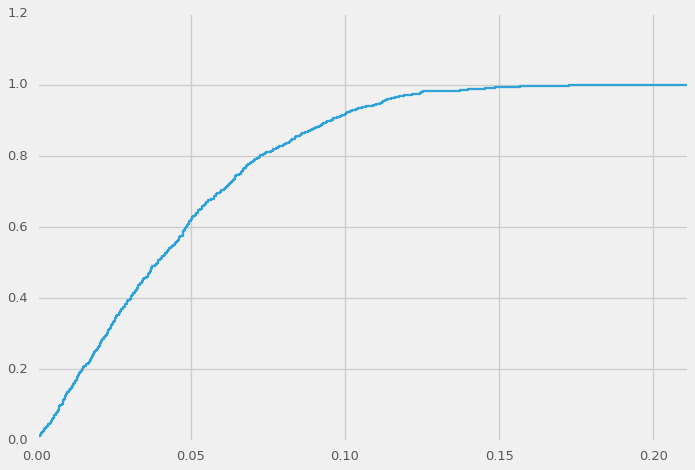

In [108]:
diffcdf = runpool(firstsbabylengths, othersbabylengths)
diffcdf.plot(drawstyle='steps');

In [109]:
firstsbabylengths.mean() - othersbabylengths.mean()

0.078037266777549519

In [118]:
1.-diffcdf.loc[.0780:].iloc[0]

0.17699999999999938

The p-value is about 0.17, which means that we expect to see a difference as big as the observed effect about 17% of the time. So this effect is not statistically significant.

## <font color='steelblue'>Run the same analysis with birthweight</font>

In [119]:
firsts_weights = firsts.totalwgt_lb.dropna().as_matrix()
others_weights =  others.totalwgt_lb.dropna().as_matrix()

print(firsts_weights.mean() - others_weights.mean())

-0.124761184535


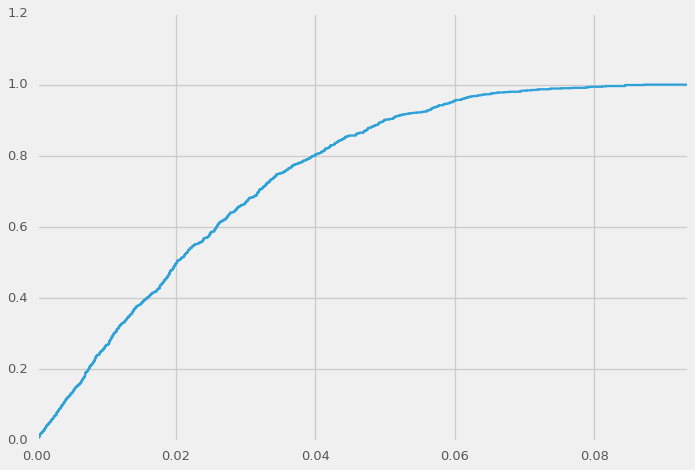

In [120]:
diffweightscdf = runpool(firsts_weights, others_weights)
diffweightscdf.plot(drawstyle='steps');

If we run the same analysis with birth weight, the computed p-value is 0; after 1000 attemps, the simulation never yields an effect as big as the observed difference, 0.12 lbs. So we would report $p < 0.001$, and conclude that hte difference in birth weight is statistically significant.

## <font color='steelblue'>Other test statistics</font>

Choosing the best test statistic depends on what question you are trying to address. For example, if the relevant quesotion is whether pregnancy lengths are different for first babies, then it makes sense to test the absolute difference in means, as we did in the previous section.

If we had reason to think that first babies are likely to be late, then we would not take the absolute value of the difference; instead we would use this test statistic:

```
test_stat = group1.mean() - group2.mean()
```

This kind of test is called **one-sided** because it only counts one side of the distribution of differences. The prevous test, using both sides, is **two-sided**.

In [146]:
def runpool_onesided(one, two, m = 1000):
    difflist = []
    pool = np.hstack((one, two))
    n = one.shape[0]
    for _ in range(m):
        np.random.shuffle(pool)
        new_one, new_two = pool[:n], pool[n:]
        difference = new_one.mean() - new_two.mean()
        difflist.append(difference)
    diffser = pd.Series(difflist)
    diffcdf = diffser.value_counts(normalize=True).sort_index().cumsum()
    return diffcdf

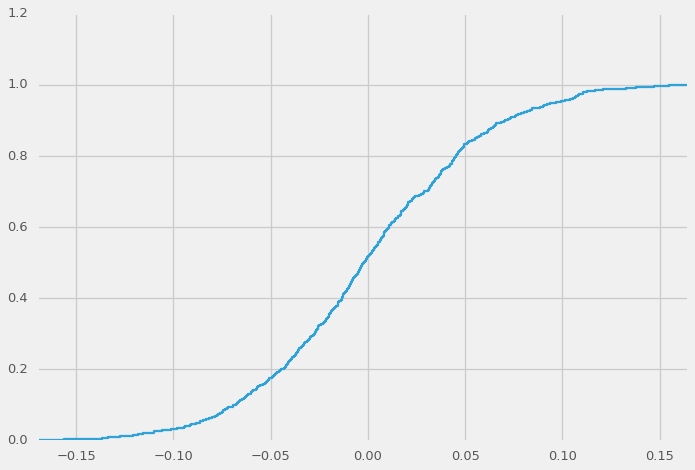

In [147]:
diffcdf = runpool_onesided(firstsbabylengths, othersbabylengths)
diffcdf.plot(drawstyle='steps');

In [148]:
1.-diffcdf.loc[.0780:].iloc[0]

0.081999999999999296

For this version of the test, the p-value is 0.0819. In general the p-value for a one-sided test is about half the p-value for a two-sided test, depending on the shape of the distribution.

The one-sided hypothesis, that first babies are born late, is more specific than the two-sided hypothesis, so the p-value is smaller. But even for the stronger hypothesis, the difference is not statistically significant.

We can use the same framework to test for a difference in standard deviation. We earlier saw some evidence that first babies are more likely to be early or late, and less likely to be on time. So we might hypothesize that the standard deviation is higher.

In [149]:
def runpool_onesided_std(one, two, m = 1000):
    difflist = []
    pool = np.hstack((one, two))
    n = one.shape[0]
    for _ in range(m):
        np.random.shuffle(pool)
        new_one, new_two = pool[:n], pool[n:]
        difference = new_one.std() - new_two.std()
        difflist.append(difference)
    diffser = pd.Series(difflist)
    diffcdf = diffser.value_counts(normalize=True).sort_index().cumsum()
    return diffcdf

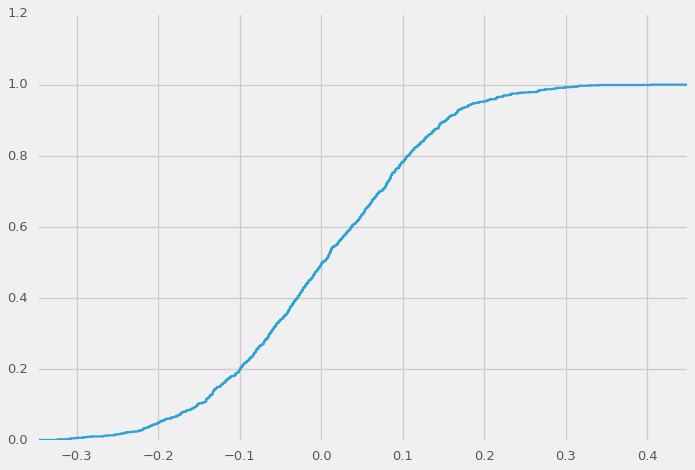

In [150]:
diffcdf = runpool_onesided_std(firstsbabylengths, othersbabylengths)
diffcdf.plot(drawstyle='steps');

In [152]:
firstsbabylengths.std() - othersbabylengths.std()

0.17600895913991677

In [153]:
1.-diffcdf.loc[.176:].iloc[0]

0.06399999999999928

This is a one-sided test because the hypothesis is that the standard deviation for first babies is higher, not just different. The p-value is 0.063, which is not statistically significant.

In general a negative hypothesis test does not imply that there is no difference between the groups; instead it suggests that if there is a difference, it is too small to detect with this sample size.

In [157]:
psertreatment, pcdftreatment = SenatorAstute(level=.95,p=.81815, n = 8568)

confidence level: 0.95 is the interval, (0.80999066293183941, 0.82609710550887017) is the ci
stderr: 0.004121270042328186
best estimate: 0.810072459146473 to 0.8262275408535271


In [158]:
psercontrol, pcdfcontrol = SenatorAstute(level=.95,p=.797, n = 8568)

confidence level: 0.95 is the interval, (0.78839869281045738, 0.80555555555555558) is the ci
stderr: 0.004366503123159255
best estimate: 0.7884418111402263 to 0.8055581888597738


In [159]:
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])

In [160]:
preg = nsfg.ReadFemPreg()
complete = preg.query('outcome in [1,3,4]').prglngth
completecdf = complete.value_counts(normalize=True).sort_index().cumsum()

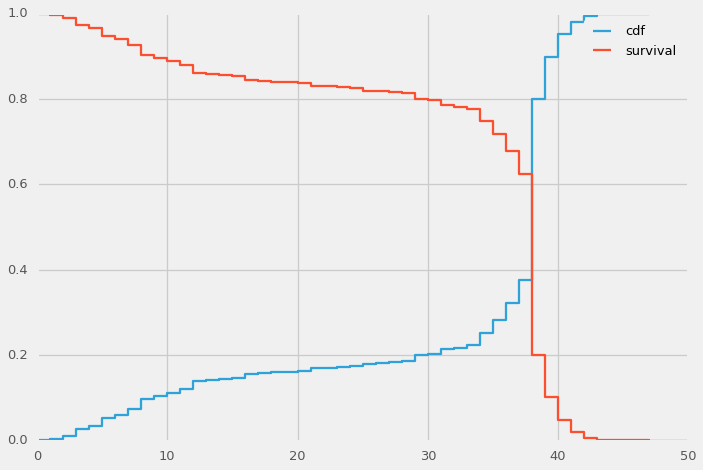

In [162]:
ax = completecdf.plot(drawstyle='steps',label='cdf')
surv = 1 - completecdf
surv.plot(drawstyle='steps',ax=ax,label='survival')
plt.legend();

In [164]:
print(surv[13])
print(completecdf[13])

0.86021985879
0.13978014121


## <font color='steelblue'>Hazard function</font>

From the survival curve we can derive the **hazard function**; for pregnancy lengths, the hazard function maps from a time, t, to the fraction of pregnancies that continue until t and then end at t. To be more precise:

$
\lambda(t) = \frac{S(t) - S(t+1)}{S(t)}
$

The numerator is the fraction of lifetimes that end at t, which is also PMF(t).